# Convert numpy arrays to dataframes to work with in R

In [30]:
import os
import sys
import pandas as pd
import numpy as np

sys.path.insert(0, '../')

from locations import location_output

In [31]:
selection_rows = []
flux_rows = []
results_keys = ["pan_data","smoking","nonsmoking","smoking_plus","nonsmoking_plus"]
# results_keys = ["pan_data","smoking_plus","nonsmoking_plus"]
# results_keys = ["smoking_plus"]
Mk = "M2"
gene_or_pathway = "genes"

#for method in ["variant","cesR"]:
for method in ["cesR"]:

    directory = location_output + "/output_for_transfer/" + gene_or_pathway + "/" + method + "/" + Mk + "/"
    
    fluxes_mles = {
        key: np.load(directory + key + "_" + "fluxes_mles.npy", allow_pickle=True).item()
        for key in results_keys
    }

    fluxes_cis = {
        key: np.load(directory + key + "_" + "fluxes_cis.npy", allow_pickle=True).item()
        for key in results_keys
    }

    selection_mles = {
        key: np.load(directory + key + "_" + "selections_mles.npy", allow_pickle=True).item()
        for key in results_keys
    }

    selection_cis = {
        key: np.load(directory + key + "_" + "selections_cis.npy", allow_pickle=True).item()
        for key in results_keys
    }



if Mk == "M1" or Mk == "M1_all":
    for key, gene_data in selection_mles.items():
        for gene, selection in gene_data.items():
            selection_ci = list(selection_cis[key][gene].values())[0]
            selection_row = [method, key, gene[0], list(selection.values())[0], selection_ci[0], selection_ci[1]]
            selection_rows.append(selection_row)

    for key, gene_data in fluxes_mles.items():
        for gene, flux in gene_data.items():
            flux_ci = list(fluxes_cis[key][gene].values())[0]
            flux_row = [method, key, gene[0], list(flux.values())[0], flux_ci[0], flux_ci[1]]
            flux_rows.append(flux_row)
elif Mk == "M2":
    for key, gene_data in selection_mles.items():
        for combo, mutations in gene_data.items():
            for mutation, selection_mle in mutations.items():
                selection_ci = selection_cis[key][combo][mutation]
                selection_row = [method, key, combo[0], combo[1], mutation, selection_mle, selection_ci[0], selection_ci[1]]
                selection_rows.append(selection_row)

    for key, gene_data in fluxes_mles.items():
        for combo, mutations in gene_data.items():
            for mutation, flux_mle in mutations.items():
                flux_ci = fluxes_cis[key][combo][mutation]
                flux_row = [method, key, combo[0], combo[1], mutation, flux_mle, flux_ci[0], flux_ci[1]]
                flux_rows.append(flux_row)
elif Mk == "M3":
    for key, gene_data in selection_mles.items():
        for combo, mutations in gene_data.items():
            for mutation, selection_mle in mutations.items():
                selection_ci = selection_cis[key][combo][mutation]
                selection_row = [method, key, combo[0], combo[1], combo[2], mutation, selection_mle, selection_ci[0], selection_ci[1]]
                selection_rows.append(selection_row)

    for key, gene_data in fluxes_mles.items():
        for combo, mutations in gene_data.items():
            for mutation, flux_mle in mutations.items():
                flux_ci = fluxes_cis[key][combo][mutation]
                flux_row = [method, key, combo[0], combo[1], combo[2], mutation, flux_mle, flux_ci[0], flux_ci[1]]
                flux_rows.append(flux_row)
else:
    raise Exception('invalid Mk')

In [32]:
if Mk == "M1" or Mk == "M1_all":
    selection_df = pd.DataFrame(selection_rows, columns=['method', 'key', 'gene', 'gamma_mle', 'gamma_ci_low', 'gamma_ci_high'])
    flux_df = pd.DataFrame(flux_rows, columns=['method', 'key', 'gene', 'flux_mle', 'flux_ci_low', 'flux_ci_high'])
elif Mk == "M2":
    selection_df = pd.DataFrame(selection_rows, columns=['method', 'key', 'first_gene', 'second_gene', 'mutation', 'gamma_mle', 'gamma_ci_low', 'gamma_ci_high'])
    flux_df = pd.DataFrame(flux_rows, columns=['method', 'key', 'first_gene', 'second_gene', 'mutation', 'flux_mle', 'flux_ci_low', 'flux_ci_high'])
elif Mk == "M3":
    selection_df = pd.DataFrame(selection_rows, columns=['method', 'key', 'first_gene', 'second_gene', 'third_gene', 'mutation', 'gamma_mle', 'gamma_ci_low', 'gamma_ci_high'])
    flux_df = pd.DataFrame(flux_rows, columns=['method', 'key', 'first_gene', 'second_gene', 'third_gene', 'mutation', 'flux_mle', 'flux_ci_low', 'flux_ci_high'])
else:
    raise Exception('invalid Mk')

In [33]:
selection_df.to_csv(Mk + "_gene_gammas.csv", index=False)
flux_df.to_csv(Mk + "_gene_fluxes.csv", index=False)
mutation_rates_df.to_csv("mutation_rates.csv", index=False)

In [34]:
cesR_mu_df = pd.read_csv(os.path.join(location_output, 'output_for_transfer/genes/mus',
                                                          'pan_data_mutation_rates.txt'),
                                                          index_col=0).assign(key = "pan_data")
cesR_mu_df = pd.concat([cesR_mu_df,
                       pd.read_csv(os.path.join(location_output, 'output_for_transfer/genes/mus',
                                                          'smoking_mutation_rates.txt'),
                                                          index_col=0).assign(key = "smoking")])
cesR_mu_df = pd.concat([cesR_mu_df,
                       pd.read_csv(os.path.join(location_output, 'output_for_transfer/genes/mus',
                                                          'nonsmoking_mutation_rates.txt'),
                                                          index_col=0).assign(key = "nonsmoking")])

cesR_mu_df = cesR_mu_df.assign(method = "cesR")
cesR_mu_df = cesR_mu_df.reset_index()
cesR_mu_df.columns = "gene", "rate", "rate_ci_low", "rate_ci_high", "key", "method"

In [36]:
variant_based_mutation_rates = pd.read_csv(os.path.join(location_output, 'output_for_transfer/genes/mus',
                                                        'variant_based_mutation_rates.txt'),
                                                        index_col=0)
variant_based_mutation_rates.columns = "pan_data","smoking","nonsmoking"
variant_based_mutation_rates = variant_based_mutation_rates.to_dict()

variant_mu_data = [("variant",key, gene, rate) for key, gene_rates in variant_based_mutation_rates.items()
        for gene, rate in gene_rates.items()]

variant_mu_df = pd.DataFrame(variant_mu_data, columns=['method', 'key', 'gene', 'rate'])

In [39]:
mutation_rates_df = pd.concat([cesR_mu_df, variant_mu_df])

In [41]:
selection_df.to_csv(Mk + "_gene_gammas.csv", index=False)
flux_df.to_csv(Mk + "_gene_fluxes.csv", index=False)
mutation_rates_df.to_csv("mutation_rates.csv", index=False)

In [40]:
mutation_rates_df

,gene,rate,rate_ci_low,rate_ci_high,key,method
0,A1BG,1.672345e-06,0.000002,0.000002,pan_data,cesR
1,A1CF,3.495583e-06,0.000003,0.000004,pan_data,cesR
2,A2M,1.712413e-06,0.000002,0.000002,pan_data,cesR
3,A2ML1,2.495659e-06,0.000002,0.000003,pan_data,cesR
4,A3GALT2,1.056848e-06,0.000001,0.000001,pan_data,cesR
...,...,...,...,...,...,...
5824,AK4,NaN,NaN,NaN,nonsmoking,variant
5825,OXA1L,1.304412e-09,NaN,NaN,nonsmoking,variant
5826,IL1B,3.632504e-10,NaN,NaN,nonsmoking,variant
5827,CPEB3,NaN,NaN,NaN,nonsmoking,variant


# Plotting trajectories

In [1]:
import os
import sys
import pandas as pd
import numpy as np

sys.path.insert(0, '../')

from locations import location_output

from landscape_plotting import plot_landscape
from landscape_plotting import positions_landscape

from theory import order_pos_lambdas
from theory import build_S_as_array

fluxes_mles = dict()
fluxes_cis = dict()
selection_mles = dict()
selection_cis = dict()

In [2]:
# Dataset keys for results
results_keys = ["pan_data","smoking","nonsmoking","smoking_plus","nonsmoking_plus"]
# Assessing gene-level results or pathway-level results
gene_or_pathway = "genes"

for i in range(1,4):
    Mk = "M" + str(i)

    #for method in ["variant","cesR"]:
    for method in ["cesR"]:

        directory = location_output + "/output_for_transfer/" + gene_or_pathway + "/" + method + "/" + Mk + "/"
        
        fluxes_mles[Mk] = {
            key: np.load(directory + key + "_" + "fluxes_mles.npy", allow_pickle=True).item()
            for key in results_keys
        }

        fluxes_cis[Mk] = {
            key: np.load(directory + key + "_" + "fluxes_cis.npy", allow_pickle=True).item()
            for key in results_keys
        }

        selection_mles[Mk] = {
            key: np.load(directory + key + "_" + "selections_mles.npy", allow_pickle=True).item()
            for key in results_keys
        }

        selection_cis[Mk] = {
            key: np.load(directory + key + "_" + "selections_cis.npy", allow_pickle=True).item()
            for key in results_keys
        }

In [3]:
cesR_mu_df = pd.read_csv(os.path.join(location_output, 'output_for_transfer',gene_or_pathway,'mus',
                                                          'pan_data_mutation_rates.txt'),
                                                          index_col=0).assign(key = "pan_data")
cesR_mu_df = pd.concat([cesR_mu_df,
                       pd.read_csv(os.path.join(location_output, 'output_for_transfer',gene_or_pathway,'mus',
                                                          'smoking_mutation_rates.txt'),
                                                          index_col=0).assign(key = "smoking")])
cesR_mu_df = pd.concat([cesR_mu_df,
                       pd.read_csv(os.path.join(location_output, 'output_for_transfer',gene_or_pathway,'mus',
                                                          'nonsmoking_mutation_rates.txt'),
                                                          index_col=0).assign(key = "nonsmoking")])

cesR_mu_df = cesR_mu_df.assign(method = "cesR")
cesR_mu_df = cesR_mu_df.reset_index()
cesR_mu_df.columns = "gene", "rate", "rate_ci_low", "rate_ci_high", "key", "method"

cesR_mu_dict = cesR_mu_df.drop(["method","rate_ci_low","rate_ci_high"],axis=1).groupby('key').apply(lambda x: dict(zip(x.gene, x.rate))).to_dict()

In [4]:
sample_dict = dict()
for k in range(2,4):
    Mk = "M"+str(k)
    sample_dict[Mk] = dict()

    sample_keys = list(positions_landscape(k, 'left_to_right').keys())
    empty_keys = np.where([-1 in tup for tup in list(positions_landscape(k, 'left_to_right').keys())])[0]

    for dataset_key in results_keys:
        sample_dict[Mk][dataset_key] = dict()

        Mk_samples = pd.read_csv('../../output/output_for_transfer/genes/cesR/' + Mk + '/samples_per_combination_' + dataset_key + '.csv')
        gene_combos = Mk_samples.gene_combination.to_list()
        for row in range(len(gene_combos)):
            #gene_combo_key_name = tuple(gene_combos[row].strip('()').split(","))
            gene_combo_key_name = gene_combos[row]
            sample_dict[Mk][dataset_key][gene_combo_key_name] = dict()
            for i in range(len(sample_keys)):
                if i in empty_keys:
                    sample_dict[Mk][dataset_key][gene_combo_key_name][sample_keys[i]] = 0
                else: 
                    sample_dict[Mk][dataset_key][gene_combo_key_name][sample_keys[i]] = Mk_samples.loc[row,str(sample_keys[i])]


In [9]:
def plot_trajectory(gene_list, dataset_key, param="selection", scale_circle_areas=0.01,multiplier_font_size=1.5,scale_arrows=None):
    if not isinstance(gene_list,list):
        raise TypeError("`gene_list` must be a list of genes")
    if param not in ["fixation","mutation","selection"]: 
        raise ValueError("`param` must be one of 'fixation','mutation','selection'")
    if scale_arrows is None:
        if param == "fixation": scale_arrows = 1
        elif param == "mutation": scale_arrows = 1*10**5
        elif param == "selection": scale_arrows = 0.5*10**(-6)
    
    Mk = "M" + str(len(gene_list))
    gene_tuple = tuple(gene_list)

    if param == "fixation": values = fluxes_mles[Mk][dataset_key][gene_tuple]
    elif param == "mutation": 
        T = order_pos_lambdas(build_S_as_array(len(gene_list))) # list of transitions
        T_ = np.array(T)
        mutated_indices = np.where(T_[:,1] - T_[:,0])[1] # mutated gene for each transition
        values = {T[i]: cesR_mu_dict[dataset_key][gene_tuple[mutated_indices[i]]] for i in range(len(T))} # create dictionary with mutation rates
    elif param == "selection": values = selection_mles[Mk][dataset_key][gene_tuple]

    p = plot_landscape(
        arrows = values,
        circle_areas = sample_dict[Mk][dataset_key][str(gene_tuple)],
        mutation_names = gene_tuple,
        scale_arrows=scale_arrows,
        positions="left_to_right",
        include_n_circles=True,
        scale_circle_areas=scale_circle_areas,
        multiplier_font_size=multiplier_font_size,
        plot_name='trajectory' + dataset_key + '_'.join(gene_tuple) + param
    )
    return p

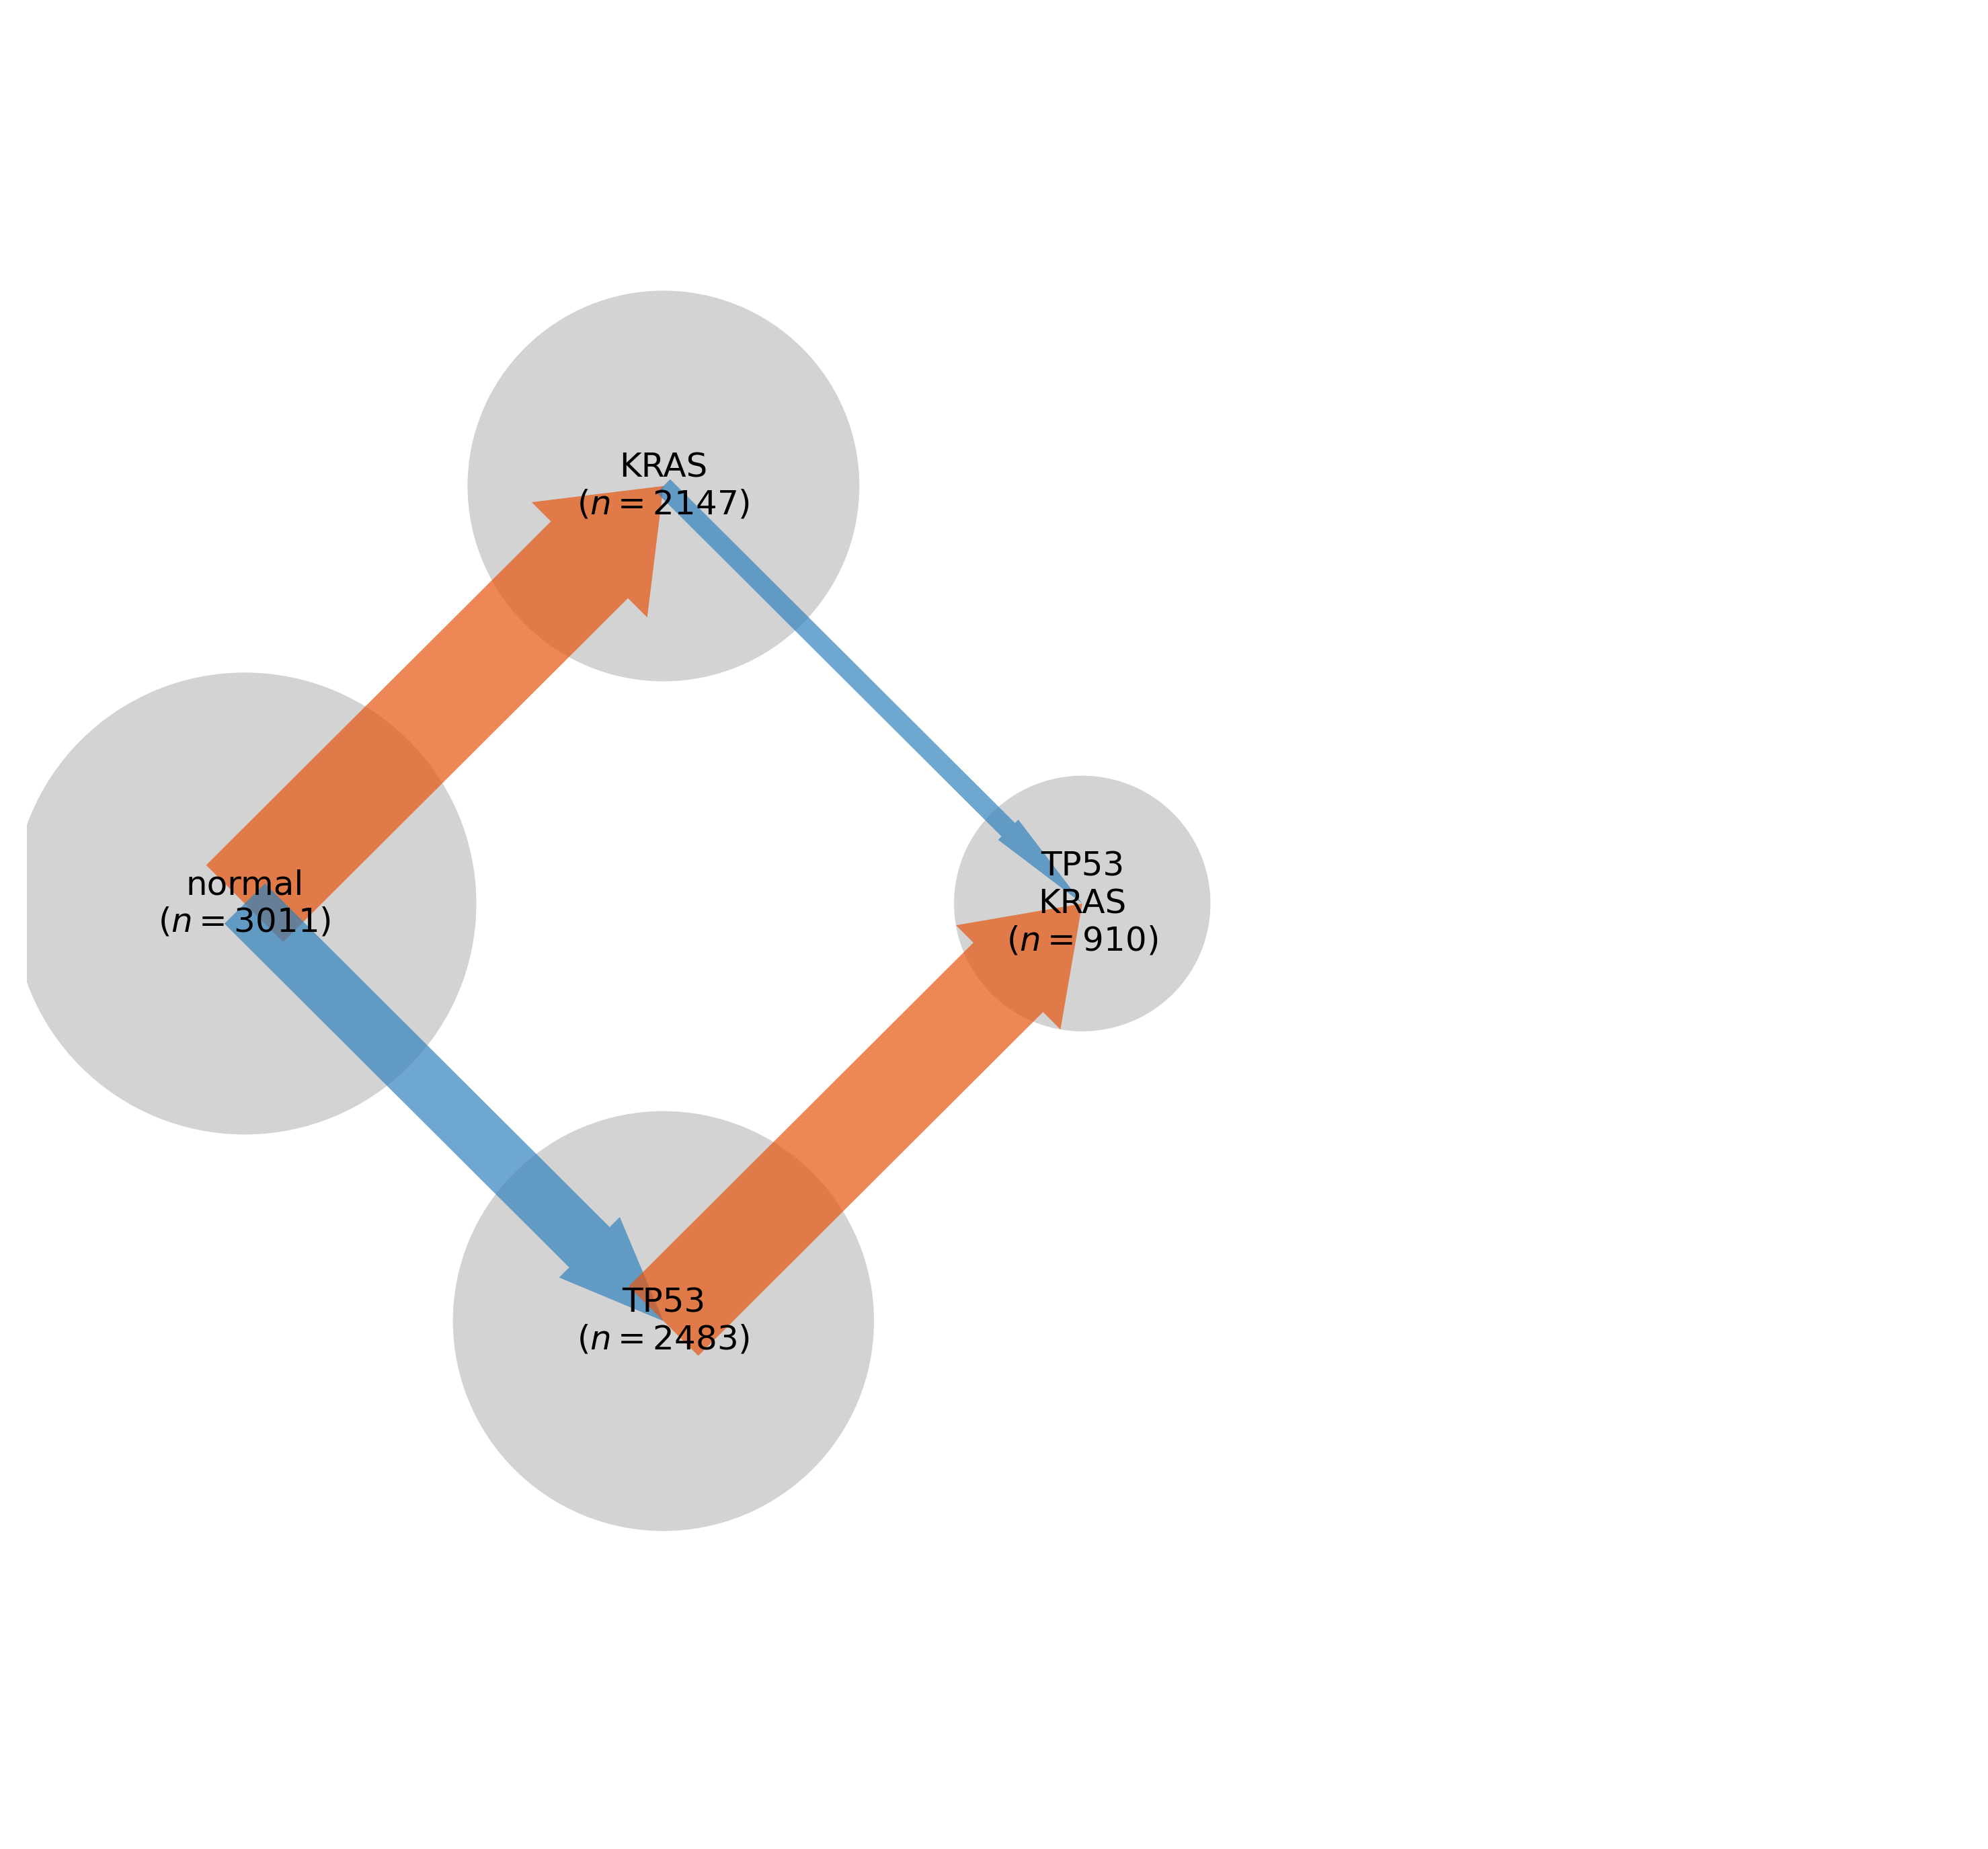

In [26]:
plot_trajectory(['TP53', 'KRAS'],'pan_data','selection')

## For higher order interaction plot

### Fitness Rescue
#### CTNNB1 ['BRAF', 'CTNNB1', 'KEAP1']

### Super-synergism

#### RB1 ['TP53', 'PIK3CA', 'RB1']

#### APC ['TP53', 'ATM', 'APC']

### Less benefit than expected

#### CTNNB1 ['TP53', 'EGFR', 'CTNNB1']

#### KEAP1 ['KRAS', 'CTNNB1', 'KEAP1']

# Pathways

In [21]:
hm_df = pd.read_csv("../../data/gene_sets/hallmark_pathway_df.csv")

#HALLMARK_TNFA_SIGNALING_VIA_NFKB = list(hm_df[hm_df["pathway"]=="HALLMARK_TNFA_SIGNALING_VIA_NFKB"]["genes"])[0].split("|")
HALLMARK_HYPOXIA = list(hm_df[hm_df["pathway"]=="HALLMARK_HYPOXIA"]["genes"])[0].split("|")
HALLMARK_WNT_BETA_CATENIN_SIGNALING = list(hm_df[hm_df["pathway"]=="HALLMARK_WNT_BETA_CATENIN_SIGNALING"]["genes"])[0].split("|")
HALLMARK_DNA_REPAIR = list(hm_df[hm_df["pathway"]=="HALLMARK_DNA_REPAIR"]["genes"])[0].split("|")
HALLMARK_G2M_CHECKPOINT = list(hm_df[hm_df["pathway"]=="HALLMARK_G2M_CHECKPOINT"]["genes"])[0].split("|")

HALLMARK_PI3K_AKT_MTOR_SIGNALING = list(hm_df[hm_df["pathway"]=="HALLMARK_PI3K_AKT_MTOR_SIGNALING"]["genes"])[0].split("|")
HALLMARK_MYC_TARGETS_V2 = list(hm_df[hm_df["pathway"]=="HALLMARK_MYC_TARGETS_V2"]["genes"])[0].split("|")
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION = list(hm_df[hm_df["pathway"]=="HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"]["genes"])[0].split("|")
HALLMARK_INFLAMMATORY_RESPONSE = list(hm_df[hm_df["pathway"]=="HALLMARK_INFLAMMATORY_RESPONSE"]["genes"])[0].split("|")
HALLMARK_METABOLISM = list(hm_df[hm_df["pathway"]=="HALLMARK_OXIDATIVE_PHOSPHORYLATION"]["genes"])[0].split("|") + list(hm_df[hm_df["pathway"]=="HALLMARK_GLYCOLYSIS"]["genes"])[0].split("|")

HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY = list(hm_df[hm_df["pathway"]=="HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"]["genes"])[0].split("|")
HALLMARK_P53_PATHWAY = list(hm_df[hm_df["pathway"]=="HALLMARK_P53_PATHWAY"]["genes"])[0].split("|")
HALLMARK_ANGIOGENESIS = list(hm_df[hm_df["pathway"]=="HALLMARK_ANGIOGENESIS"]["genes"])[0].split("|")
HALLMARK_KRAS = list(hm_df[hm_df["pathway"]=="HALLMARK_KRAS_SIGNALING_UP"]["genes"])[0].split("|") + list(hm_df[hm_df["pathway"]=="HALLMARK_KRAS_SIGNALING_DN"]["genes"])[0].split("|")